# Applying River Formation Dynamics to the Steiner Tree Problem (STP)

In [1]:
import igraph as ig
import numpy as np
from rfd_utils import Drop
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output

## Auxiliar functions

In [2]:
def generateSTPGraph(fname):
    with open(fname, 'r', newline='') as f:
        line = f.readline()
        
        while line.strip()!='SECTION Graph':
            line = f.readline()

        line = f.readline().split()
        assert line[0]=='Nodes'
        nNodes = int(line[1])
        g = ig.Graph(n=nNodes)

        line = f.readline().split()
        assert line[0]=='Edges'
        nEdges = int(line[1])

        for _ in range(nEdges):
            line = f.readline().split()
            assert line[0]=='E'
            n1 = int(line[1])-1
            n2 = int(line[2])-1
            d  = float(line[3])

            e = g.add_edge(n1, n2)
            e['distance'] = d

        line = f.readline()
        while line.strip()!='SECTION Terminals':
            line = f.readline()

        
        line = f.readline().split()
        assert line[0]=='Terminals'
        nTerminals = int(line[1])

        terminals = []
        for i in range(nTerminals):
            line = f.readline().split()
            assert line[0]=='T'
            t = int(line[1])-1

            terminals.append(t)

        line = f.readline()
        while line.strip()!='EOF':
            line = f.readline()
        # g.delete_vertices(0)

        return g, terminals

In [3]:
def colorTerminals(graph, terminals):
    colors = []
    t_i = 0
    terms = np.sort(terminals)
    for i, v in enumerate(graph.vs):
        if v.index == terms[t_i]:
            t_i = (t_i + 1)%len(terms)
            colors.append('red')
        else:
            colors.append('white')
    return colors

In [4]:
def graphPlot(graph, terminals):
    plot = ig.plot(graph, #target=ax,
        # vertex_size=20,
        vertex_color=colorTerminals(graph, terminals),
        vertex_label=graph.vs.indices,
        # layout = 'circular',
        bbox=(0, 0, 500, 500),
        )
    return plot

In [5]:
# g, t = generateSTPGraph('data/b01.stp')
# graphPlot(g, t)

In [6]:
def modifySTPGraph(graph, SPM):
    # graph = graph_orig.copy()
    nNodes = len(graph.vs)
    graph.es['orig_dist'] = graph.es['distance']
    for i in range(nNodes):
        for j in range(i+1, nNodes):
            try:
                i_edge = graph.get_eid(i, j)
                if graph.es[i_edge]['distance'] > SPM[i][j]:
                    # Only in non-euclidean geometries
                    graph.delete_edges(i_edge)
                    e = graph.add_edge(i, j)
                    e['distance'] = SPM[i][j]
                    e['orig_dist'] = np.inf
            except:
                # edge (i, j) does not exist in the graph
                e = graph.add_edge(i, j)
                e['distance'] = SPM[i][j]
                e['orig_dist'] = np.inf
    # return graph

## RFD functions for STP

In [7]:
def insertDrops(graph, n=1, node=1):
    for _ in range(n):
        graph.vs[node]['drops'].append(Drop(origin=node))

### Gradients computation
$$decreasingGradient(i,j) = \frac{altitude(i) - altitude(j)}{distance(i,j)} $$

Also computes the angle between the nodes as follows (which will be used later):
$$ angle(i,j) = \begin{cases} 90 - \sigma & \text{if } decreasingGradient(i,j) < 0 \\ 90 - \eta & \text{if } decreasingGradient(i,j) = 0 \\ 90 + \sigma & \text{if } decreasingGradient(i,j) > 0 \end{cases}$$
where
$$\begin{equation} \sigma = \left| \arctan (\left| decreasingGradient(i,j) \right| ) \right| \cdot (180 \cdot \pi) \\ \eta = edgeCost / \mu \end{equation} $$

<div style="text-align:center">
    <img src="./imgs/angle.jpg" height="100"/>
</div>

In [8]:
def computeDecGradientsSTP(graph, i_origin, grads, mu):
    neighbors = graph.neighbors(i_origin)
    decrGrads = np.zeros_like(grads[0])
    i_edges = graph.get_eids([(i_origin, i_dest) for i_dest in neighbors])
    grads[i_origin][neighbors] = (graph.vs[i_origin]['altitude'] - np.array(graph.vs['altitude'])[neighbors]) / np.array(graph.es['distance'])[i_edges]

    for i_dest in neighbors:
        i_edge = graph.get_eid(i_origin, i_dest)

        if grads[i_origin][i_dest] < 0:
            dG = 90 - np.abs(np.arctan(np.abs(grads[i_origin][i_dest]))) * (180 / np.pi)
        elif grads[i_origin][i_dest] == 0:
            dG = 90 - (graph.es[i_edge]['distance'] / mu)
        elif grads[i_origin][i_dest] > 0:
            dG = 90 + np.abs(np.arctan(np.abs(grads[i_origin][i_dest]))) * (180 / np.pi)
        else:
            raise ValueError('invalid gradient %f' % grads[i_origin][i_dest])
        grads[i_origin][i_dest] = dG
        
    # return np.array(decrGrads)
    return grads[i_origin]

### Drop movement
Each drop $k$ moves randomly from node $i$ to node $j$ according to the following probability rule:
$$ P_k(i,j) = \begin{cases} \frac{angle(i,j)}{\sum_{l \in V_k(i)}angle(i,l)} & \text{if } j \in V_k(i) \\ 0  & \text{if } j \notin V_k(i)\end{cases}$$
where $V_k(i)$ is the set of nodes that are neighbors of node $i$ and can be visited by drop $k$.

In [9]:
def moveSingleDrop(drop, next_node):
    drop.path.append(next_node)
    # drop.moved = True # Not necessary
    return drop

# def notMoveSingleDrop(drop):
#     drop.moved = False
#     return drop
    
def moveDropsSTP(graph, grads, mu):
    # print(graph.vs['drops'])
    # print('*'*20)
    nextIterDrops = [[] for i in graph.vs]
    for node in graph.vs:
        drops = node['drops']
        decrGrads = computeDecGradientsSTP(graph, node.index, grads, mu)
        if drops:
            np.random.shuffle(drops) # Random shuffle
            # print(node.index)
            # Compute probabilities from drecreasinGradients
            
            dG = np.delete(decrGrads, node.index) # Remove self node
            probs = dG / sum(dG)
            # print(probs)
            numDrops = len(drops)
            neighbors = graph.neighbors(node)
            totalMoved = 0
            # Deterministically move some drops
            for i, p in enumerate(probs):
                nextNode = neighbors[i]
                numMove = int(np.floor(numDrops * p))
                movedDrops = [moveSingleDrop(drop, nextNode) for drop in drops[totalMoved:totalMoved+numMove]]
                nextIterDrops[nextNode] += movedDrops
                totalMoved += numMove
            # Move remaining drops randomly
            for drop in drops[totalMoved:]:
                nextNode = np.random.choice(neighbors, p=probs)
                nextIterDrops[nextNode].append(moveSingleDrop(drop, nextNode))
    # Assign drops to new nodes
    graph.vs['drops'] = nextIterDrops
    # print('*'*20)
    # print(nextIterDrops)
    return

### Analysis of paths

A solution is iteratively constructed by adding the edge with highest gradient that connects a terminal node with the partially constructed solution. The root of the solution tree is always the first terminal


In [10]:
def analyzeSTPPaths(graph, terminals, decrGrads):
    solTree = [terminals[0]]
    solution = []
    costSolution = 0
    realCost = 0
    terms = np.copy(terminals[1:])
    np.random.shuffle(terms)
    while not all(node in solTree for node in terminals):
        grad = -1
        e = None
        orig = None
        dest = None
        for t in terms:
            if t not in solTree:
                for n in solTree:
                    if decrGrads[t, n] > grad:
                        e = graph.get_eid(t, n)
                        grad = decrGrads[t, n]
                        orig = n
                        dest = t

        # e is the edge with the highest gradient 
        # that connects a terminal node with the
        # partially constructed tree.
        path = graph.get_shortest_paths(orig, to=dest, weights='orig_dist', mode='ALL')[0]
        # print(path)
        if len(path) > 2:
            solution.append(e)
            costSolution += graph.es[e]['distance']
            # print('costSolution', costSolution)
        # add to solution the rest of the edges 
        # belonging to the shortest path 
        for i in range(1, len(path)):
            if path[i] not in solTree:
                solTree.append(path[i])
                # print('path Nodes:', path[i-1], path[i])
                e = graph.get_eid(path[i-1], path[i])
                solution.append(e)
                costSolution += graph.es[e]['distance']
                realCost += graph.es[e]['distance']
    return solution, costSolution, realCost

### Paths erosion

For each edge connecting two nodes $i$ and $j$ belonging to the solution created in the $analyzePaths()$ pahse, we erode the node $i$ in the following way:

$$altitude(i) = altitude(i) - \frac{\phi \cdot numberOfDrops \cdot decreasingGradient(i,j)}{costSolution},$$

where $numberOfDrops$ is the number of drops that traversed the edge in that exectution turn.

In [11]:
def computeNumDrops(graph, orig, i_dest):
    drops = graph.vs[i_dest]['drops']
    count = 0
    for d in drops:
        if d.path[-2] == orig:
            count =+ 1
    return count


def erodePathsSTP(graph, solution, costSolution, phi, grads):
    totalErosion = 0
    for i_edge in solution:
        node_i = graph.es[i_edge].source
        node_j = graph.es[i_edge].target
        numberOfDrops = computeNumDrops(graph, node_i, node_j) + computeNumDrops(graph, node_j, node_i)
        erosion_i = np.sum((phi * numberOfDrops * grads[node_i][node_j]) / costSolution)
        erosion_j = np.sum((phi * numberOfDrops * grads[node_j][node_i]) / costSolution)
        graph.vs[node_i]['altitude'] -= erosion_i
        graph.vs[node_j]['altitude'] -= erosion_j
        totalErosion += erosion_i + erosion_j
    return totalErosion

### Sedimentation
The sediments eroded in previous phase are distributed among all nodes.

In [12]:
def depositSediments(graph, erosionProduced):
    graph.vs['altitude'] = np.array(graph.vs['altitude']) + erosionProduced/(len(graph.vs))

## RFD Algorithm for STP

In [13]:
def RFDsolverSTP(graph, terminals, numDropsTerm=100, mu=5, phi=0.1, maxSteps=100):
    print('Original graph:')
    print(graph.summary())
    print('{} terminal nodes:'.format(len(terminals)), terminals)
    print()

    # Preprocessing
    SPM = graph.shortest_paths_dijkstra(weights='distance',mode='ALL')
    modifySTPGraph(graph, SPM)
    print('Modified graph:')
    print(graph.summary())
    print()

    # RFD Algorithm
    print('Computing STP via RFD algorithm...')
    # Initialization
    numNodes = len(graph.vs)
    decreasingGradient = np.zeros((numNodes, numNodes))
    cost_l = []
    iter_l = []
    steps=0

    # initializeDrops
    graph.vs['drops'] = [[] for _ in graph.vs]
    for t in terminals[1:]:
        insertDrops(graph, numDropsTerm, t)

    # initializeNodes
    graph.vs['altitude'] = 10000
    # graph.vs[terminals[0]]['altitude'] = 0

    tic = time.time()
    # while (not allDropsFollowTheSamePath()) and (not otherEndingCondition())
    while (steps < maxSteps):
        # moveDrops
        moveDropsSTP(graph, decreasingGradient, mu)

        # analyzePaths
        solution, costSolution, realCost = analyzeSTPPaths(graph,
                                                        terminals,
                                                        decreasingGradient
                                                        )
        # erodePaths
        totalErosion = erodePathsSTP(graph,
                                    solution,
                                    costSolution,
                                    phi,
                                    decreasingGradient
                                    )
        # depositSediments
        depositSediments(graph, totalErosion)

        steps += 1
        cost_l.append(realCost)
        iter_l.append(steps)

        # # Re-insert fallen drops
        # newDrops = len(graph.vs[terminals[0]]['drops'])
        # for _ in range(newDrops):
        #     t = np.random.choice(terminals[1:])
        #     insertDrops(graph, 1, t)
        # graph.vs[terminals[0]]['drops'] = []        

    # end while
    toc = time.time()

    # print(solution, realCost)
    print('Cost of last solution:',realCost)
    print('Elapsed time:', toc-tic)

    return cost_l, iter_l

## Execution examples

In [14]:
# mySTP, term = generateSTPGraph('data/sample_stp.txt')
mySTP, terminals = generateSTPGraph('data/b01.stp')

mySTP.summary(), terminals

('IGRAPH U--- 50 63 -- \n+ attr: distance (e)',
 [47, 48, 21, 34, 26, 11, 36, 33, 23])

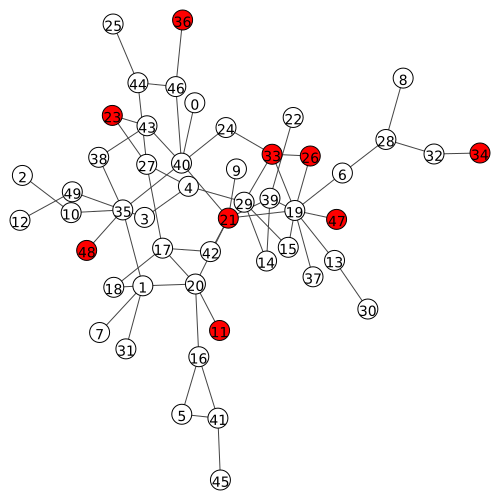

In [15]:
graphPlot(mySTP, terminals)

Original graph:
IGRAPH U--- 50 63 -- 
+ attr: distance (e)
9 terminal nodes: [47, 48, 21, 34, 26, 11, 36, 33, 23]

Modified graph:
IGRAPH U--- 50 1225 -- 
+ attr: distance (e), orig_dist (e)

Computing STP via RFD algorithm...
Cost of last solution: 82.0
Elapsed time: 0.9204199314117432


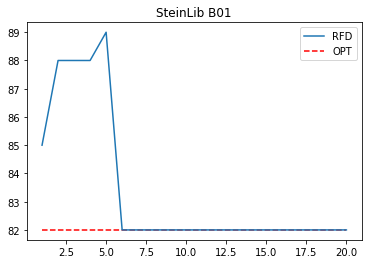

In [16]:
mySTP, terminals = generateSTPGraph('data/b01.stp')
cost, it = RFDsolverSTP(mySTP, terminals, numDropsTerm=10, maxSteps=20)

# Plotting
plt.plot(it, cost, label='RFD')
plt.hlines(82, xmin=it[0], xmax=it[-1], linestyles='--', colors='r', label='OPT')
plt.title('SteinLib B01')
plt.legend()
plt.show()

Original graph:
IGRAPH U--- 50 63 -- 
+ attr: distance (e)
13 terminal nodes: [24, 22, 18, 8, 6, 10, 38, 5, 40, 39, 27, 42, 48]

Modified graph:
IGRAPH U--- 50 1225 -- 
+ attr: distance (e), orig_dist (e)

Computing STP via RFD algorithm...
Cost of last solution: 84.0
Elapsed time: 1.132725715637207


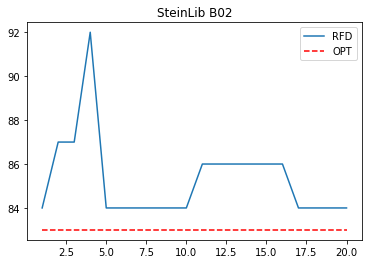

In [17]:
mySTP, terminals = generateSTPGraph('data/b02.stp')
cost, it = RFDsolverSTP(mySTP, terminals, numDropsTerm=10, maxSteps=20)

# Plotting
plt.plot(it, cost, label='RFD')
plt.hlines(83, xmin=it[0], xmax=it[-1], linestyles='--', colors='r', label='OPT')
plt.title('SteinLib B02')
plt.legend()
plt.show()

Original graph:
IGRAPH U--- 50 63 -- 
+ attr: distance (e)
25 terminal nodes: [31, 1, 8, 35, 47, 19, 38, 41, 15, 49, 40, 0, 27, 11, 12, 33, 9, 24, 3, 43, 48, 14, 23, 37, 36]

Modified graph:
IGRAPH U--- 50 1225 -- 
+ attr: distance (e), orig_dist (e)

Computing STP via RFD algorithm...
Cost of last solution: 153.0
Elapsed time: 2.6911020278930664


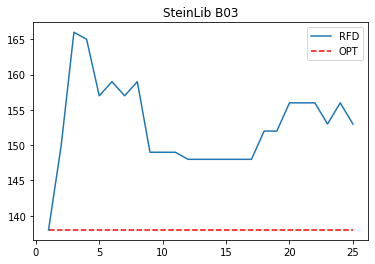

In [18]:
mySTP, terminals = generateSTPGraph('data/b03.stp')
cost, it = RFDsolverSTP(mySTP, terminals, numDropsTerm=31, maxSteps=25)

# Plotting
plt.plot(it, cost, label='RFD')
plt.hlines(138, xmin=it[0], xmax=it[-1], linestyles='--', colors='r', label='OPT')
plt.title('SteinLib B03')
plt.legend()
plt.show()

Original graph:
IGRAPH U--- 50 100 -- 
+ attr: distance (e)
9 terminal nodes: [34, 40, 38, 24, 41, 48, 35, 21, 37]

Modified graph:
IGRAPH U--- 50 1225 -- 
+ attr: distance (e), orig_dist (e)

Computing STP via RFD algorithm...
Cost of last solution: 77.0
Elapsed time: 2.6811625957489014


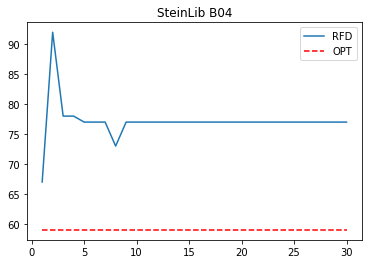

In [19]:
mySTP, terminals = generateSTPGraph('data/b04.stp')
cost, it = RFDsolverSTP(mySTP, terminals, numDropsTerm=100, maxSteps=30)

# Plotting
plt.plot(it, cost, label='RFD')
plt.hlines(59, xmin=it[0], xmax=it[-1], linestyles='--', colors='r', label='OPT')
plt.title('SteinLib B04')
plt.legend()
plt.show()

Original graph:
IGRAPH U--- 50 100 -- 
+ attr: distance (e)
13 terminal nodes: [4, 23, 6, 22, 2, 14, 15, 12, 19, 36, 30, 34, 38]

Modified graph:
IGRAPH U--- 50 1225 -- 
+ attr: distance (e), orig_dist (e)

Computing STP via RFD algorithm...
Cost of last solution: 68.0
Elapsed time: 1.367168664932251


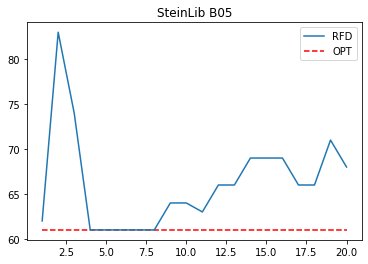

In [20]:
mySTP, terminals = generateSTPGraph('data/b05.stp')
cost, it = RFDsolverSTP(mySTP, terminals, numDropsTerm=25, maxSteps=20)

# Plotting
plt.plot(it, cost, label='RFD')
plt.hlines(61, xmin=it[0], xmax=it[-1], linestyles='--', colors='r', label='OPT')
plt.title('SteinLib B05')
plt.legend()
plt.show()

Original graph:
IGRAPH U--- 75 94 -- 
+ attr: distance (e)
13 terminal nodes: [54, 51, 59, 62, 23, 25, 69, 35, 28, 50, 22, 58, 13]

Modified graph:
IGRAPH U--- 75 2775 -- 
+ attr: distance (e), orig_dist (e)

Computing STP via RFD algorithm...
Cost of last solution: 113.0
Elapsed time: 2.39713191986084


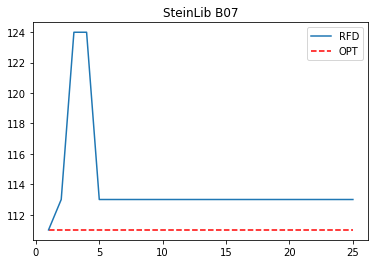

In [21]:
mySTP, terminals = generateSTPGraph('data/b07.stp')
cost, it = RFDsolverSTP(mySTP, terminals, numDropsTerm=10, maxSteps=25)

# Plotting
plt.plot(it, cost, label='RFD')
plt.hlines(111, xmin=it[0], xmax=it[-1], linestyles='--', colors='r', label='OPT')
plt.title('SteinLib B07')
plt.legend()
plt.show()

## References
* P. Rabanal, I. Rodríguez, and F. Rubio, “Studying the application of ant colony optimization and river formation dynamics to the steiner tree problem,” Evol. Intell., vol. 4, no. 1, pp. 51–65, 2011, doi: [10.1007/s12065-011-0049-0](https://www.doi.org/10.1007/s12065-011-0049-0).
* P. Rabanal, I. Rodríguez, and F. Rubio, “Solving dynamic TSP by using river formation dynamics,” Proc. - 4th Int. Conf. Nat. Comput. ICNC 2008, vol. 1, pp. 246–250, 2008, doi: [10.1109/ICNC.2008.760](https://www.doi.org/10.1109/ICNC.2008.760).